In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# ---------------------------------------------------------
# 1. 환경변수 로드 (notebooks 폴더의 상위 폴더에 있는 .env 로드)
# ---------------------------------------------------------
load_dotenv(dotenv_path="../.env")

# 2. DB 연결
DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": int(os.getenv("DB_PORT", 3306)),
    "user": os.getenv("DB_USER", "admin"),
    "password": os.getenv("DB_PASSWORD"),
    "db": os.getenv("DB_NAME", "projectl")
}

db_url = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['db']}"
engine = create_engine(db_url)
print("✅ DB 연결 성공!")

# ---------------------------------------------------------
# 3. 데이터 수집 함수 (스키마 컬럼명 수정 완료)
# ---------------------------------------------------------
def get_item_data(item_name):
    conn = engine.connect()
    try:
        # (1) 아이템 ID 찾기
        item_sql = text("SELECT id FROM market_items WHERE name = :name")
        item_id = conn.execute(item_sql, {"name": item_name}).scalar()
        
        if not item_id:
            print(f"❌ '{item_name}' 아이템을 찾을 수 없습니다.")
            return None, None

        print(f"🔍 '{item_name}' (ID: {item_id}) 데이터 수집 중...")

        # (2) 가격 로그 가져오기 (컬럼명: current_min_price, logged_at)
        price_sql = text("""
            SELECT logged_at, current_min_price
            FROM market_price_logs
            WHERE item_id = :item_id
            ORDER BY logged_at ASC
        """)
        df_prices = pd.read_sql(price_sql, conn, params={"item_id": item_id})
        
        # (3) GPT Score 가져오기 (컬럼명: notice_date, gpt_score)
        notice_sql = text("""
            SELECT r.notice_date, i.gpt_score
            FROM item_notice_impacts i
            JOIN raw_notices r ON i.notice_id = r.id
            WHERE i.item_id = :item_id
            ORDER BY r.notice_date ASC
        """)
        df_notices = pd.read_sql(notice_sql, conn, params={"item_id": item_id})
        
        print(f"   - 가격 로그: {len(df_prices)}개")
        print(f"   - 관련 공지: {len(df_notices)}개")
        
        return df_prices, df_notices

    finally:
        conn.close()

# ---------------------------------------------------------
# [테스트] 아이템 이름 입력
# ---------------------------------------------------------
TARGET_ITEM = "유물 원한 각인서"  # 👈 분석하고 싶은 아이템 이름
df_raw, df_gpt = get_item_data(TARGET_ITEM)

display(df_raw.head())
display(df_gpt.head())

✅ DB 연결 성공!
🔍 '유물 원한 각인서' (ID: 65200505) 데이터 수집 중...
   - 가격 로그: 7479개
   - 관련 공지: 8개


,logged_at,current_min_price
0,2025-12-18 11:00:22.041111,178699
1,2025-12-18 11:10:59.700297,177998
2,2025-12-18 11:21:36.873504,178800
3,2025-12-18 11:32:12.909622,178000
4,2025-12-18 11:42:48.640077,178000


,notice_date,gpt_score
0,2025-12-17,0.0
1,2025-12-24,0.0
2,2025-12-31,0.0
3,2026-01-07,0.3
4,2026-01-14,0.0


In [3]:
import numpy as np
from datetime import timedelta

# =========================================================
# [업그레이드] 함수 1: 원본 청소 후 30분봉 만들기
# =========================================================
def preprocess_ohlc_and_fill(df_raw):
    print("🧹 [1단계] Raw 데이터 정제 및 30분봉 변환...")
    
    df = df_raw.copy()
    
    # 1. 인덱스 설정 (필수)
    if 'logged_at' in df.columns:
        df['logged_at'] = pd.to_datetime(df['logged_at'])
        df.set_index('logged_at', inplace=True)

    # -----------------------------------------------------
    # 🚨 [핵심 추가] 원본(10분 단위) 단계에서 이상치 1차 제거
    # -----------------------------------------------------
    # 10분 데이터이므로 하루(24시간)를 보려면 window가 약 144개 필요합니다.
    # (6개/시간 * 24시간 = 144)
    raw_window = 432
    raw_sigma = 7 # 원본은 변동성이 더 크니 2.0보다 살짝 여유 있게 2.5 추천
    
    # 원본 가격 컬럼: 'current_min_price'
    rolling_mean = df['current_min_price'].rolling(window=raw_window, center=True).mean()
    rolling_std = df['current_min_price'].rolling(window=raw_window, center=True).std()
    
    upper = rolling_mean + (raw_sigma * rolling_std)
    lower = rolling_mean - (raw_sigma * rolling_std)
    
    outliers = (df['current_min_price'] > upper) | (df['current_min_price'] < lower)
    cnt = outliers.sum()
    
    if cnt > 0:
        print(f"   ✨ 원본 데이터에서 {cnt}개의 이상치를 미리 제거했습니다!")
        df.loc[outliers, 'current_min_price'] = np.nan
        df['current_min_price'] = df['current_min_price'].interpolate(method='linear')
    # -----------------------------------------------------
    
    # 2. 30분 단위 Resampling (이제 깨끗한 재료로 요리합니다)
    df_resampled = df['current_min_price'].resample('30min').agg(['first', 'max', 'min', 'last', 'mean'])
    df_resampled.columns = ['Open', 'High', 'Low', 'Close', 'Price_Mean']
    
    # 3. 빈칸 채우기
    df_filled = df_resampled.ffill().bfill()
    
    print(f"   - 정제 완료: {len(df_filled)}개 구간 (30분봉)")
    return df_filled

# =========================================================
# [추가됨] 함수 1.5: 이상치 제거 (Rolling Z-Score)
# =========================================================
def clean_outliers_rolling(df, column='Close', window=48, sigma=3):
    print(f"🧼 [1.5단계] 이상치 제거 중... (Window={window}, Sigma={sigma})")
    df_clean = df.copy()
    
    # 이동 평균과 표준편차 계산
    rolling_mean = df_clean[column].rolling(window=window, center=True).mean()
    rolling_std = df_clean[column].rolling(window=window, center=True).std()
    
    # 이상치 판별 기준
    upper_bound = rolling_mean + (sigma * rolling_std)
    lower_bound = rolling_mean - (sigma * rolling_std)
    
    # 이상치 조건 확인 및 개수 카운트
    outlier_mask = (df_clean[column] > upper_bound) | (df_clean[column] < lower_bound)
    outlier_count = outlier_mask.sum()
    
    if outlier_count > 0:
        print(f"   🚨 {outlier_count}개의 튀는 가격 발견! 부드럽게 보정합니다.")
        # 이상치를 NaN으로 변경 후 보간(Interpolation)
        df_clean.loc[outlier_mask, column] = np.nan
        df_clean[column] = df_clean[column].interpolate(method='linear')
    else:
        print("   ✅ 데이터가 아주 깨끗합니다.")
        
    return df_clean

# =========================================================
# 함수 2: GPT 스코어 매핑 (날짜 계산 로직)
# =========================================================
def apply_gpt_scores(df_price, df_gpt):
    print("🤖 [2단계] GPT 공지사항 점수 매핑 중...")
    
    df = df_price.copy()
    df['GPT_Score'] = 0.0 # 기본값 0
    
    if df_gpt is None or df_gpt.empty:
        print("   - 공지사항 데이터가 없습니다. (점수 0으로 진행)")
        return df

    count = 0
    for idx, row in df_gpt.iterrows():
        notice_date = pd.to_datetime(row['notice_date'])
        score = row['gpt_score']
        
        # [규칙 적용] 공지일 10:00 ~ 7일 뒤 06:00
        start_time = notice_date.replace(hour=10, minute=0, second=0)
        end_time = (notice_date + timedelta(days=7)).replace(hour=6, minute=0, second=0)
        
        # 해당 기간 마스킹
        mask = (df.index >= start_time) & (df.index < end_time)
        
        if mask.any():
            df.loc[mask, 'GPT_Score'] = score
            count += 1
            
    print(f"   - 총 {count}건의 공지사항 점수 반영 완료")
    return df

# =========================================================
# [실행] 파이프라인 연결 (순서 중요!)
# =========================================================

# 1. 가격 데이터 1차 정제 (빈칸 채우기)
df_temp = preprocess_ohlc_and_fill(df_raw)

# 2. [추가] 이상치 제거 (여기서 튀는 값을 잡습니다!)
df_clean_price = clean_outliers_rolling(df_temp, column='Price_Mean', window=48, sigma=3)

# 3. GPT 점수 결합
df_final = apply_gpt_scores(df_clean_price, df_gpt)

# 4. 결과 확인
print("-" * 30)
print(f"🗓️ 데이터 기간: {df_final.index.min()} ~ {df_final.index.max()}")
print("-" * 30)
display(df_final.tail())

🧹 [1단계] Raw 데이터 정제 및 30분봉 변환...
   - 정제 완료: 2592개 구간 (30분봉)
🧼 [1.5단계] 이상치 제거 중... (Window=48, Sigma=3)
   🚨 3개의 튀는 가격 발견! 부드럽게 보정합니다.
🤖 [2단계] GPT 공지사항 점수 매핑 중...
   - 총 8건의 공지사항 점수 반영 완료
------------------------------
🗓️ 데이터 기간: 2025-12-18 11:00:00 ~ 2026-02-10 10:30:00
------------------------------


,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-10 08:30:00,152000.0,152000.0,152000.0,152000.0,152000.000000,0.0
2026-02-10 09:00:00,151999.0,151999.0,151800.0,151800.0,151899.333333,0.0
2026-02-10 09:30:00,151800.0,151800.0,151600.0,151600.0,151733.333333,0.0
2026-02-10 10:00:00,151790.0,151790.0,150900.0,151399.0,151363.000000,0.0
2026-02-10 10:30:00,150500.0,150500.0,150500.0,150500.0,150500.000000,0.0


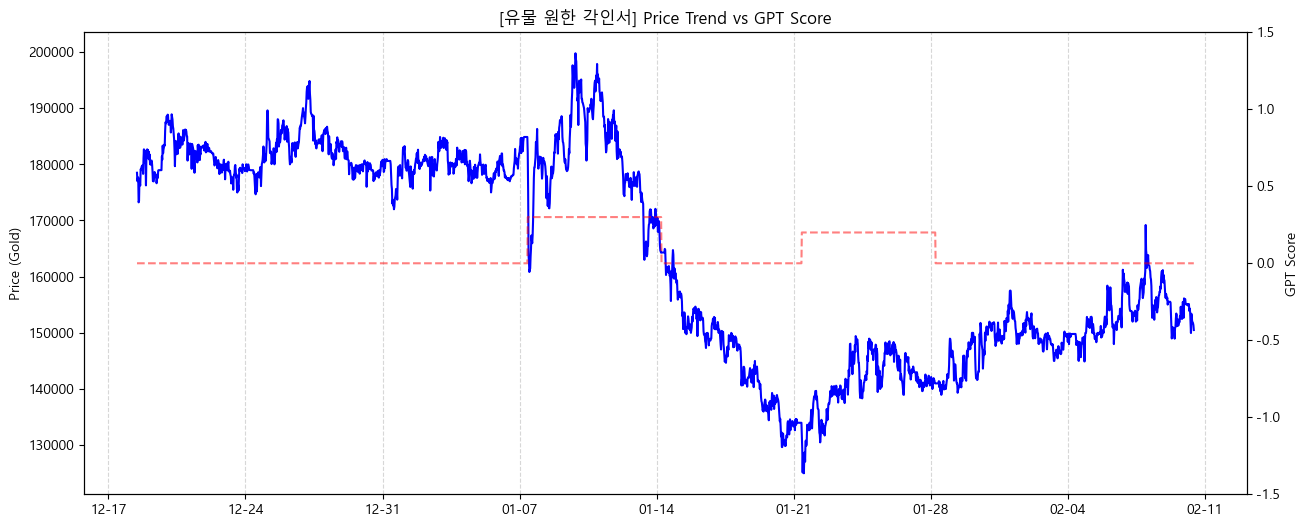

,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-10 08:30:00,152000.0,152000.0,152000.0,152000.0,152000.000000,0.0
2026-02-10 09:00:00,151999.0,151999.0,151800.0,151800.0,151899.333333,0.0
2026-02-10 09:30:00,151800.0,151800.0,151600.0,151600.0,151733.333333,0.0
2026-02-10 10:00:00,151790.0,151790.0,150900.0,151399.0,151363.000000,0.0
2026-02-10 10:30:00,150500.0,150500.0,150500.0,150500.0,150500.000000,0.0


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 3. 시각화 (확인용)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# 가격 그래프 (파란색)
ax1 = plt.gca()
ax1.plot(df_final.index, df_final['Price_Mean'], color='blue', label='Avg Price')
ax1.set_ylabel('Price (Gold)')

# GPT 점수 그래프 (빨간색, y축 공유)
ax2 = ax1.twinx()
ax2.plot(df_final.index, df_final['GPT_Score'], color='red', linestyle='--', alpha=0.5, label='GPT Score')
ax2.set_ylabel('GPT Score')
ax2.set_ylim(-1.5, 1.5)

# 2. 눈금 형식: '월-일' 형태로 보여줘라 (예: 01-29)
# 연도까지 보고 싶으면 '%Y-%m-%d'로 바꾸시면 됩니다.
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.grid(True, which='major', axis='x', linestyle='--', alpha=0.5) # 수요일마다 세로 점선 추가

plt.title(f"[{TARGET_ITEM}] Price Trend vs GPT Score")
plt.show()

# 데이터 확인
display(df_final.tail())

In [5]:
import numpy as np

# 1. 원본 복사
df_ml = df_final.copy()

# ---------------------------------------------------------
# 2. 기술적 지표 (이동평균, 변동성, RSI)
# ---------------------------------------------------------
# 가격의 흐름(Trend)을 모델에게 알려줍니다.
df_ml['MA_5'] = df_ml['Close'].rolling(window=5).mean()    # 2.5시간 평균
df_ml['MA_48'] = df_ml['Close'].rolling(window=48).mean()  # 24시간(1일) 평균
df_ml['Std_20'] = df_ml['Close'].rolling(window=20).std()  # 변동성

# RSI (상대강도지수)
delta = df_ml['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_ml['RSI'] = 100 - (100 / (1 + rs))

# ---------------------------------------------------------
# 3. [핵심] Lag Features (시차 데이터)
# ---------------------------------------------------------
# 모델 학습용으로 "과거의 정답"을 미리 만들어두는 겁니다.
# (나중에 예측할 때는 이 컬럼을 우리가 직접 채워넣으며 예측해야 합니다)
df_ml['Close_Lag1'] = df_ml['Close'].shift(1)  # 30분 전
df_ml['Close_Lag2'] = df_ml['Close'].shift(2)  # 1시간 전
df_ml['GPT_Lag1'] = df_ml['GPT_Score'].shift(1) # 30분 전 공지 점수

# ---------------------------------------------------------
# 4. 시간 정보 (Time Features)
# ---------------------------------------------------------
# 미래의 시간(요일, 시간)은 우리가 달력만 보면 100% 알 수 있으므로 아주 좋은 힌트입니다.
df_ml['Hour'] = df_ml.index.hour
df_ml['DayOfWeek'] = df_ml.index.dayofweek # 0:월 ~ 6:일

# ---------------------------------------------------------
# 5. Target (정답지: 다음 30분 뒤의 가격)
# ---------------------------------------------------------
df_ml['Target'] = df_ml['Close'].shift(-1)

# 결측치 제거 (이동평균 등으로 생긴 앞부분 빈칸 삭제)
df_ml = df_ml.dropna()

print(f"📚 머신러닝 데이터 준비 완료: {df_ml.shape}")
display(df_ml.tail())

📚 머신러닝 데이터 준비 완료: (2544, 16)


,Open,High,Low,Close,Price_Mean,GPT_Score,MA_5,MA_48,Std_20,RSI,Close_Lag1,Close_Lag2,GPT_Lag1,Hour,DayOfWeek,Target
logged_at,,,,,,,,,,,,,,,,
2026-02-10 08:00:00,153400.0,153400.0,152000.0,152000.0,152866.666667,0.0,151748.6,153254.375000,1790.029465,35.592036,153400.0,150000.0,0.0,8,1,152000.0
2026-02-10 08:30:00,152000.0,152000.0,152000.0,152000.0,152000.000000,0.0,151460.0,153275.208333,1790.766731,37.216947,152000.0,153400.0,0.0,8,1,151800.0
2026-02-10 09:00:00,151999.0,151999.0,151800.0,151800.0,151899.333333,0.0,151840.0,153293.958333,1847.765994,35.402593,152000.0,152000.0,0.0,9,1,151600.0
2026-02-10 09:30:00,151800.0,151800.0,151600.0,151600.0,151733.333333,0.0,152160.0,153308.541667,1850.984151,34.756098,151800.0,152000.0,0.0,9,1,151399.0
2026-02-10 10:00:00,151790.0,151790.0,150900.0,151399.0,151363.000000,0.0,151759.8,153337.687500,1838.009744,32.959742,151600.0,151800.0,0.0,10,1,150500.0


📚 XGB 학습 데이터: (2247, 9) ( ~ 2026-02-04 06:00:00)
📝 XGB 검증 데이터: (297, 9)

🔥 XGBoost 학습 시작...
✅ XGBoost 학습 완료!
🔮 지금(2026-02-10 10:00:00)부터 향후 3일간 예측 시작...
✅ XGB 미래 예측 완료!


,날짜,예측가격
0,2026-02-10 10:30:00,151022.921875
1,2026-02-10 11:00:00,151005.140625
2,2026-02-10 11:30:00,151005.140625
3,2026-02-10 12:00:00,151005.140625
4,2026-02-10 12:30:00,151058.750000



📊 [XGBoost 3일 예측 리포트]
   - 예상 최저가: 150937 G
   - 예상 최고가: 151453 G
   - 3일 뒤 마감: 151026 G


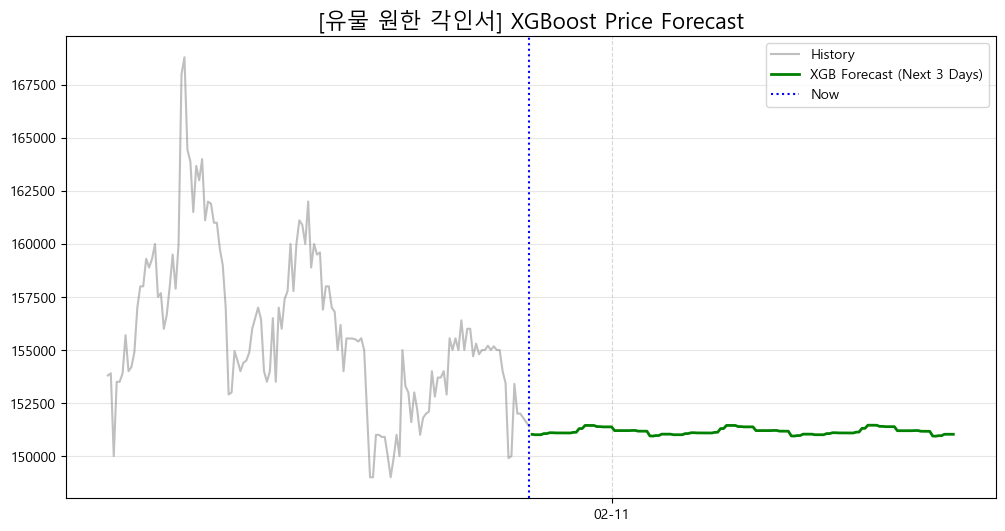

In [6]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# ---------------------------------------------------------
# 1. 학습 데이터 준비 (규칙: 2월 4일 06:00 이전만 사용)
# ---------------------------------------------------------
# df_ml은 이미 정제 및 피처 엔지니어링이 끝난 데이터라고 가정합니다.
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")

features = [
    'MA_5', 'MA_48', 'Std_20', 'RSI',
    'Close_Lag1', 'Close_Lag2', 'GPT_Lag1',
    'Hour', 'DayOfWeek'
]
target = 'Target'

# 학습용 데이터 (Cutoff 이전)
X_train = df_ml[df_ml.index < train_cutoff][features]
y_train = df_ml[df_ml.index < train_cutoff][target]

# 검증용 데이터 (Cutoff 이후 ~ 현재) - 과적합 방지용
X_valid = df_ml[df_ml.index >= train_cutoff][features]
y_valid = df_ml[df_ml.index >= train_cutoff][target]

print(f"📚 XGB 학습 데이터: {X_train.shape} ( ~ {train_cutoff})")
print(f"📝 XGB 검증 데이터: {X_valid.shape}")

# ---------------------------------------------------------
# 2. XGBoost 모델 학습
# ---------------------------------------------------------
print("\n🔥 XGBoost 학습 시작...")
model_xgb = xgb.XGBRegressor(
    n_estimators=2000,       # 학습 횟수 (넉넉하게)
    learning_rate=0.01,      # 천천히 꼼꼼하게
    max_depth=6,             # 나무 깊이
    subsample=0.8,           # 데이터 샘플링
    colsample_bytree=0.8,    # 컬럼 샘플링
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # 50번 동안 성능 향상 없으면 멈춤
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False  # 로그 너무 많이 뜨면 지저분해서 껐습니다
)
print("✅ XGBoost 학습 완료!")

# ---------------------------------------------------------
# 3. [핵심] 미래 3일 재귀적 예측 (Recursive Forecasting)
# ---------------------------------------------------------
# NeuralProphet은 알아서 해주지만, XGB는 우리가 직접 Loop를 돌려야 합니다.
print(f"🔮 지금({df_ml.index[-1]})부터 향후 3일간 예측 시작...")

future_predictions = []
future_dates = []

# 가장 마지막 데이터(현재 시점)를 가져와서 시작점으로 삼습니다.
last_row = df_ml.iloc[[-1]].copy()
current_time = last_row.index[0]

# 144스텝(3일) 반복
for i in range(144):
    # 1. 현재 상태로 다음 스텝 예측
    pred_price = model_xgb.predict(last_row[features])[0]
    
    # 2. 결과 저장
    next_time = current_time + timedelta(minutes=30)
    future_predictions.append(pred_price)
    future_dates.append(next_time)
    
    # 3. [중요] 다음 예측을 위해 '과거 정보(Lags)' 업데이트 (Shift)
    # 오늘 예측한 가격(pred_price)이 내일의 '어제 가격(Lag1)'이 됩니다.
    
    # Lag2 <- Lag1 (밀어내기)
    last_row['Close_Lag2'] = last_row['Close_Lag1']
    # Lag1 <- 방금 예측한 값 (채우기)
    last_row['Close_Lag1'] = pred_price
    
    # GPT Lag (미래 공지사항은 없으므로 0으로 가정, 만약 있으면 여기서 넣어줌)
    last_row['GPT_Lag1'] = 0.0
    
    # 시간 정보 업데이트
    last_row['Hour'] = next_time.hour
    last_row['DayOfWeek'] = next_time.dayofweek
    
    # (참고) MA, RSI 등은 재귀적으로 계산하기 복잡하므로 
    # 단기 예측에서는 직전 값을 유지하거나, Lag값만으로 추세를 잡게 둡니다.
    
    # 현재 시간 갱신
    current_time = next_time

# DataFrame으로 변환
forecast_3days_xgb = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': future_predictions
})

print("✅ XGB 미래 예측 완료!")
display(forecast_3days_xgb.head())

# ---------------------------------------------------------
# 4. 결과 시각화
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# (1) 과거 데이터 (최근 5일치)
recent_view = df_ml.tail(144)
plt.plot(recent_view.index, recent_view['Close'], label='History', color='gray', alpha=0.5)

# (2) XGB 예측선
plt.plot(forecast_3days_xgb['날짜'], forecast_3days_xgb['예측가격'],
         label='XGB Forecast (Next 3 Days)', color='green', linewidth=2)

# 기준선
current_now = df_ml.index[-1]
plt.axvline(current_now, color='blue', linestyle=':', label='Now')

plt.title(f"[{TARGET_ITEM}] XGBoost Price Forecast", fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# 날짜 포맷
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5) # 수요일마다 세로 점선 추가plt.show()

# ---------------------------------------------------------
# 5. 요약 리포트
# ---------------------------------------------------------
min_xgb = forecast_3days_xgb['예측가격'].min()
max_xgb = forecast_3days_xgb['예측가격'].max()
last_xgb = forecast_3days_xgb['예측가격'].iloc[-1]

print(f"\n📊 [XGBoost 3일 예측 리포트]")
print(f"   - 예상 최저가: {min_xgb:.0f} G")
print(f"   - 예상 최고가: {max_xgb:.0f} G")
print(f"   - 3일 뒤 마감: {last_xgb:.0f} G")

💯 [모델 성적표 - 검증 데이터 기준]
   - RMSE (평균 오차): ±1861.81 골드
   - MAE (절대 오차): ±1292.28 골드
   (해석: 모델 예측이 실제 가격과 약 1292골드 정도 차이납니다.)


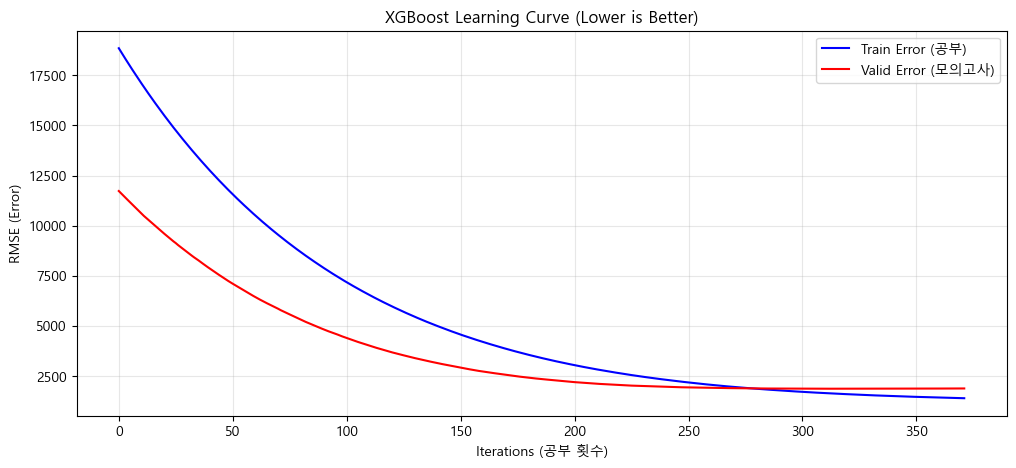

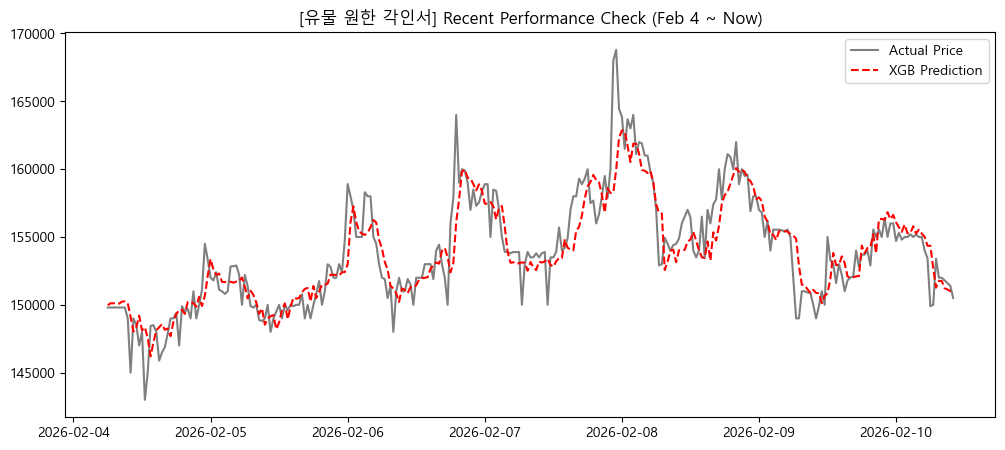

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------------------------------------------------
# 1. 점수 계산 (RMSE, MAE)
# ---------------------------------------------------------
# '모의고사(X_valid)' 문제를 풀게 시킵니다.
valid_preds = model_xgb.predict(X_valid)

# 채점 (실제 정답 y_valid와 비교)
rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
mae = mean_absolute_error(y_valid, valid_preds)

print(f"💯 [모델 성적표 - 검증 데이터 기준]")
print(f"   - RMSE (평균 오차): ±{rmse:.2f} 골드")
print(f"   - MAE (절대 오차): ±{mae:.2f} 골드")
print(f"   (해석: 모델 예측이 실제 가격과 약 {int(mae)}골드 정도 차이납니다.)")

# ---------------------------------------------------------
# 2. 학습 곡선 (Learning Curve) - 모델이 공부를 잘 했나?
# ---------------------------------------------------------
# 모델이 학습하면서 오차가 어떻게 줄어들었는지 보여줍니다.
results = model_xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Error (공부)', color='blue')
plt.plot(x_axis, results['validation_1']['rmse'], label='Valid Error (모의고사)', color='red')
plt.title('XGBoost Learning Curve (Lower is Better)')
plt.xlabel('Iterations (공부 횟수)')
plt.ylabel('RMSE (Error)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------------------------------------
# 3. 실제 vs 예측 비교 (최근 1~2일)
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_valid.index, y_valid, label='Actual Price', color='black', alpha=0.5)
plt.plot(y_valid.index, valid_preds, label='XGB Prediction', color='red', linestyle='--')
plt.title(f"[{TARGET_ITEM}] Recent Performance Check (Feb 4 ~ Now)")
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------------------------------------------------
# 3. 평가
# ---------------------------------------------------------

# ---------------------------------------------------------
# [필수] 평가 함수 다시 정의 (도구들이 import 된 상태에서)
# ---------------------------------------------------------
def get_detailed_score(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # 1. 기본 오차
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # 2. 퍼센트 오차 (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-7))) * 100
    
    # 3. 설명력 (R2)
    r2 = r2_score(y_true, y_pred)
    
    # 4. 방향 정확도
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    correct_direction = np.sum(np.sign(true_diff) == np.sign(pred_diff))
    dir_acc = (correct_direction / len(true_diff)) * 100
    
    return rmse, mae, mape, r2, dir_acc

pred_xgb = model_xgb.predict(X_valid)

rmse, mae, mape, r2, dir_acc = get_detailed_score(y_valid, pred_xgb)

print("-" * 60)
print(f"⚡ [XGBoost 성적표]")
print(f"   - RMSE: {rmse:.2f}")
print(f"   - MAE : {mae:.2f}")
print(f"   - MAPE: {mape:.2f}%")
print(f"   - r2: {r2:.2f}")
print(f"   - Dir Acc: {dir_acc:.1f}%")
print("-" * 60)

------------------------------------------------------------
⚡ [XGBoost 성적표]
   - RMSE: 1861.81
   - MAE : 1292.28
   - MAPE: 0.84%
   - r2: 0.79
   - Dir Acc: 47.0%
------------------------------------------------------------
